##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multi-task recommenders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/recommenders/examples/multitask"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/recommenders/blob/main/docs/examples/multitask.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/recommenders/blob/main/docs/examples/multitask.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/recommenders/docs/examples/multitask.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In the [basic retrieval tutorial](basic_retrieval) we built a retrieval system using movie watches as positive interaction signals.

In many applications, however, there are multiple rich sources of feedback to draw upon. For example, an e-commerce site may record user visits to product pages (abundant, but relatively low signal), image clicks, adding to cart, and, finally, purchases. It may even record post-purchase signals such as reviews and returns.

Integrating all these different forms of feedback is critical to building systems that users love to use, and that do not optimize for any one metric at the expense of overall performance.

In addition, building a joint model for multiple tasks may produce better results than building a number of task-specific models. This is especially true where some data is abundant (for example, clicks), and some data is sparse (purchases, returns, manual reviews). In those scenarios, a joint model may be able to use representations learned from the abundant task to improve its predictions on the sparse task via a phenomenon known as [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). For example, [this paper](https://openreview.net/pdf?id=SJxPVcSonN) shows that a model predicting explicit user ratings from sparse user surveys can be substantially improved by adding an auxiliary task that uses abundant click log data.

In this tutorial, we are going to build a multi-objective recommender for Movielens, using both implicit (movie watches) and explicit signals (ratings).

## Imports


Let's first get our imports out of the way.


In [2]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

In [3]:
!pip install -q scann

ERROR: Could not find a version that satisfies the requirement scann (from versions: none)
ERROR: No matching distribution found for scann


In [4]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd


In [5]:
import tensorflow_recommenders as tfrs

## Preparing the dataset

We're going to use the Movielens 100K dataset.

In [6]:
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    #"movie_genres": x["movie_genres"],
    #"bucketized_user_age": x['bucketized_user_age'],
    #'raw_user_age': x['raw_user_age'],
    #'timestamp': x['timestamp'],
    #'user_gender': x['user_gender'],
    #'user_occupation_label': x['user_occupation_label'],
    #'user_zip_code': x['user_zip_code']
})
movies = movies.map(lambda x: x["movie_title"])

And repeat our preparations for building vocabularies and splitting the data into a train and a test set:

In [7]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])
#movie_genres = ratings.batch(1_000).map(lambda x: x['movie_genres'])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
#unique_movie_genres = np.unique(np.concatenate(list(movie_genres)))

## A multi-task model

There are two critical parts to multi-task recommenders:

1. They optimize for two or more objectives, and so have two or more losses.
2. They share variables between the tasks, allowing for transfer learning.

In this tutorial, we will define our models as before, but instead of having  a single task, we will have two tasks: one that predicts ratings, and one that predicts movie watches.

The user and movie models are as before:

```python
user_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add 1 to account for the unknown token.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])
```

However, now we will have two tasks. The first is the rating task:

```python
tfrs.tasks.Ranking(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)
```

Its goal is to predict the ratings as accurately as possible.

The second is the retrieval task:

```python
tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128)
    )
)
```

As before, this task's goal is to predict which movies the user will or will not watch.

### Putting it together

We put it all together in a model class.

The new component here is that - since we have two tasks and two losses - we need to decide on how important each loss is. We can do this by giving each of the losses a weight, and treating these weights as hyperparameters. If we assign a large loss weight to the rating task, our model is going to focus on predicting ratings (but still use some information from the retrieval task); if we assign a large loss weight to the retrieval task, it will focus on retrieval instead.

In [8]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])


    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["movie_title"])
    # genres
    #genre_embeddings = self.movie_model(features['move_genres'])
    
    return (
        user_embeddings,
        movie_embeddings,
        #genre_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings,], axis=1) #genre_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)#genre_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)#, genre_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

### Rating-specialized model

Depending on the weights we assign, the model will encode a different balance of the tasks. Let's start with a model that only considers ratings.

In [9]:
#model = MovielensModel(rating_weight=1.0, retrieval_weight=0.0)
#model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [10]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [11]:
#model.fit(cached_train, epochs=3)
#metrics = model.evaluate(cached_test, return_dict=True)

#print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
#print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

The model does OK on predicting ratings (with an RMSE of around 1.11), but performs poorly at predicting which movies will be watched or not: its accuracy at 100 is almost 4 times worse than a model trained solely to predict watches.

### Retrieval-specialized model

Let's now try a model that focuses on retrieval only.

In [12]:
#model = MovielensModel(rating_weight=0.0, retrieval_weight=1.0)
#model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [13]:
#model.fit(cached_train, epochs=3)
#metrics = model.evaluate(cached_test, return_dict=True)

#print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
#print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

We get the opposite result: a model that does well on retrieval, but poorly on predicting ratings.

### Joint model

Let's now train a model that assigns positive weights to both tasks.

In [14]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))
adaOhOne = model.fit(cached_train, epochs=6)
metrics = model.evaluate(cached_test, return_dict=True)


#************************


print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/7
10/10 [==============================] - 6s 413ms/step - root_mean_squared_error: 3.2670 - factorized_top_k/top_1_categorical_accuracy: 1.2500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0021 - factorized_top_k/top_10_categorical_accuracy: 0.0050 - factorized_top_k/top_50_categorical_accuracy: 0.0279 - factorized_top_k/top_100_categorical_accuracy: 0.0575 - loss: 70378.5945 - regularization_loss: 0.0000e+00 - total_loss: 70378.5945
Epoch 2/7
10/10 [==============================] - 4s 403ms/step - root_mean_squared_error: 1.8842 - factorized_top_k/top_1_categorical_accuracy: 1.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0055 - factorized_top_k/top_10_categorical_accuracy: 0.0120 - factorized_top_k/top_50_categorical_accuracy: 0.0532 - factorized_top_k/top_100_categorical_accuracy: 0.0986 - loss: 70359.8828 - regularization_loss: 0.0000e+00 - total_loss: 70359.8828
Epoch 3/7
10/10 [==============================] - 4s 400ms/step - root_mean_squared_error

In [15]:
!mkdir models

A subdirectory or file models already exists.


In [16]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index(movies.batch(1000).map(model.movie_model), movies)

# Get recommendations.
_, titles = index(tf.constant(["80"]))
print(f"Recommendations for user 80: {titles[0, :]}")

Recommendations for user 80: [b'Graduate, The (1967)' b'High Noon (1952)' b'Bonnie and Clyde (1967)'
 b'Manchurian Candidate, The (1962)' b'Killing Fields, The (1984)'
 b'Citizen Kane (1941)' b'Taxi Driver (1976)'
 b'Godfather: Part II, The (1974)' b'Lawrence of Arabia (1962)'
 b'Annie Hall (1977)']


In [17]:
# Export the query model.

path = os.path.join('./models', "adaOhOneModel")

# Save the index.
index.save(path)

# Load it back; can also be done in TensorFlow Serving.
loaded = tf.keras.models.load_model(path)

# Pass a user id in, get top predicted movie titles back.
scores, titles = loaded(["42"])

print(f"Recommendations: {titles[0][:]}")

INFO:tensorflow:Assets written to: ./models\adaOhOneModel\assets


INFO:tensorflow:Assets written to: ./models\adaOhOneModel\assets


Recommendations: [b'Home Alone (1990)' b'Mrs. Doubtfire (1993)' b'Grease (1978)'
 b'Batman (1989)' b'Sneakers (1992)' b'Santa Clause, The (1994)'
 b'Star Trek III: The Search for Spock (1984)'
 b'Star Trek VI: The Undiscovered Country (1991)'
 b'Interview with the Vampire (1994)' b'Sleepless in Seattle (1993)']


In [18]:
adaOhOne = pd.DataFrame(adaOhOne.history)
adaOhOne

,root_mean_squared_error,factorized_top_k/top_1_categorical_accuracy,factorized_top_k/top_5_categorical_accuracy,factorized_top_k/top_10_categorical_accuracy,factorized_top_k/top_50_categorical_accuracy,factorized_top_k/top_100_categorical_accuracy,loss,regularization_loss,total_loss
0,3.267021,0.000125,0.002087,0.005013,0.027850,0.057450,54850.222656,0,54850.222656
1,1.884248,0.000137,0.005513,0.011963,0.053213,0.098587,54833.230469,0,54833.230469
2,1.153432,0.000250,0.012650,0.027125,0.109888,0.182313,54805.402344,0,54805.402344
3,1.119536,0.000262,0.018787,0.040962,0.174938,0.284775,54745.894531,0,54745.894531
4,1.109152,0.000500,0.021388,0.046012,0.199062,0.327825,54647.125000,0,54647.125000
5,1.094633,0.000425,0.022112,0.047500,0.202875,0.334388,54515.718750,0,54515.718750
6,1.079477,0.000262,0.022000,0.047125,0.201525,0.332538,54364.996094,0,54364.996094


In [19]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001))
adamOhOhOne = model.fit(cached_train, epochs=12)
metrics = model.evaluate(cached_test, return_dict=True)


#*****************************

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/12
10/10 [==============================] - 5s 404ms/step - root_mean_squared_error: 3.5811 - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0023 - factorized_top_k/top_10_categorical_accuracy: 0.0054 - factorized_top_k/top_50_categorical_accuracy: 0.0290 - factorized_top_k/top_100_categorical_accuracy: 0.0580 - loss: 70380.3139 - regularization_loss: 0.0000e+00 - total_loss: 70380.3139
Epoch 2/12
10/10 [==============================] - 4s 402ms/step - root_mean_squared_error: 3.1581 - factorized_top_k/top_1_categorical_accuracy: 1.2500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0036 - factorized_top_k/top_10_categorical_accuracy: 0.0080 - factorized_top_k/top_50_categorical_accuracy: 0.0394 - factorized_top_k/top_100_categorical_accuracy: 0.0776 - loss: 70371.9474 - regularization_loss: 0.0000e+00 - total_loss: 70371.9474
Epoch 3/12
10/10 [==============================] - 4s 403ms/step - root_mean_squared_er

In [20]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index(movies.batch(1000).map(model.movie_model), movies)

# Get recommendations.
_, titles = index(tf.constant(["80"]))
print(f"Recommendations for user 80: {titles[0, :]}")

Recommendations for user 80: [b'Third Man, The (1949)' b'Treasure of the Sierra Madre, The (1948)'
 b'Henry V (1989)' b'Wings of Desire (1987)' b'Taxi Driver (1976)'
 b'Citizen Kane (1941)' b'Manhattan (1979)' b'Graduate, The (1967)'
 b'Crumb (1994)' b'Vertigo (1958)']


In [21]:
# Export the query model.
path = os.path.join('./models', "adamOhOhOneModel")

# Save the index.
index.save(path)

# Load it back; can also be done in TensorFlow Serving.
loaded = tf.keras.models.load_model(path)

# Pass a user id in, get top predicted movie titles back.
scores, titles = loaded(["42"])

print(f"Recommendations: {titles[0][:]}")

INFO:tensorflow:Assets written to: ./models\adamOhOhOneModel\assets


INFO:tensorflow:Assets written to: ./models\adamOhOhOneModel\assets


Recommendations: [b'Terminator, The (1984)' b'Indiana Jones and the Last Crusade (1989)'
 b'When Harry Met Sally... (1989)' b'Dave (1993)' b'Maverick (1994)'
 b'Groundhog Day (1993)' b'Grease (1978)' b'True Lies (1994)'
 b'Love Bug, The (1969)' b'Clear and Present Danger (1994)']


In [22]:
adamOhOhOne = pd.DataFrame(adamOhOhOne.history)
adamOhOhOne

,root_mean_squared_error,factorized_top_k/top_1_categorical_accuracy,factorized_top_k/top_5_categorical_accuracy,factorized_top_k/top_10_categorical_accuracy,factorized_top_k/top_50_categorical_accuracy,factorized_top_k/top_100_categorical_accuracy,loss,regularization_loss,total_loss
0,3.581145,0.000100,0.002325,0.005350,0.029012,0.058000,54854.082031,0,54854.082031
1,3.158076,0.000125,0.003575,0.008025,0.039425,0.077563,54847.312500,0,54847.312500
2,2.351124,0.000150,0.005338,0.011138,0.051737,0.095812,54838.097656,0,54838.097656
3,1.346679,0.000250,0.007925,0.015850,0.067225,0.118238,54830.261719,0,54830.261719
4,1.296900,0.000238,0.011775,0.023375,0.087125,0.150912,54821.218750,0,54821.218750
5,1.117080,0.000275,0.016050,0.031413,0.115988,0.191038,54806.921875,0,54806.921875
6,1.096422,0.000438,0.019912,0.039912,0.146950,0.235738,54784.863281,0,54784.863281
7,1.069496,0.000350,0.023325,0.045825,0.173175,0.275988,54751.308594,0,54751.308594
8,1.062699,0.000375,0.024250,0.049000,0.192088,0.307300,54702.488281,0,54702.488281
9,1.048428,0.000475,0.024825,0.050963,0.203125,0.326275,54635.148438,0,54635.148438


In [23]:
adaOhOne['factorized_top_k/top_100_categorical_accuracy']

0    0.057450
1    0.098587
2    0.182313
3    0.284775
4    0.327825
5    0.334388
6    0.332538
Name: factorized_top_k/top_100_categorical_accuracy, dtype: float64

In [24]:
import matplotlib.pyplot as plt

In [25]:
#plt.plot(epochs, adaOhOne["factorized_top_k/top_100_categorical_accuracy"], label="ada")


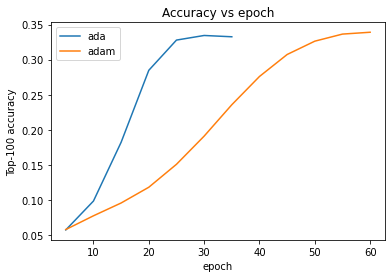

In [26]:
num_validation_runsAda = len(adaOhOne["factorized_top_k/top_100_categorical_accuracy"])
epochsAda = [(x + 1)* 5 for x in range(num_validation_runsAda)]
num_validation_runsAdam = len(adamOhOhOne["factorized_top_k/top_100_categorical_accuracy"])
epochsAdam = [(x + 1)* 5 for x in range(num_validation_runsAdam)]

plt.plot(epochsAda, adaOhOne["factorized_top_k/top_100_categorical_accuracy"], label="ada")
plt.plot(epochsAdam, adamOhOhOne["factorized_top_k/top_100_categorical_accuracy"], label="adam")
#plt.plot(epochs, rmsOhOhOne["factorized_top_k/top_100_categorical_accuracy"], label="rms")
#plt.plot(epochs, RMS_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="RMS .01")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

The result is a model that performs roughly as well on both tasks as each specialized model. 

While the results here do not show a clear accuracy benefit from a joint model in this case, multi-task learning is in general an extremely useful tool. We can expect better results when we can transfer knowledge from a data-abundant task (such as clicks) to a closely related data-sparse task (such as purchases).

In [27]:
model.summary()

Model: "movielens_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 32)                53280     
_________________________________________________________________
sequential_4 (Sequential)    (None, 32)                30208     
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 49665     
_________________________________________________________________
ranking_1 (Ranking)          multiple                  2         
_________________________________________________________________
retrieval_1 (Retrieval)      multiple                  11        
Total params: 133,166
Trainable params: 133,153
Non-trainable params: 13
_________________________________________________________________


In [28]:
"""# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "adamOhOhOneModel")

  # Save the index.
  index.save(path)

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.keras.models.load_model(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["42"])

  print(f"Recommendations: {titles[0][:]}")"""

'# Export the query model.\nwith tempfile.TemporaryDirectory() as tmp:\n  path = os.path.join(tmp, "adamOhOhOneModel")\n\n  # Save the index.\n  index.save(path)\n\n  # Load it back; can also be done in TensorFlow Serving.\n  loaded = tf.keras.models.load_model(path)\n\n  # Pass a user id in, get top predicted movie titles back.\n  scores, titles = loaded(["42"])\n\n  print(f"Recommendations: {titles[0][:]}")'